In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances
import smtplib
import schedule
import time
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText


In [3]:
df = pd.read_excel('retail.xlsx')

In [4]:
df


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [5]:
df.isna().sum()
df.dropna(inplace=True)

In [6]:
num_cols = df.select_dtypes(include='number')
cat_cols = df.select_dtypes(exclude='number')

for num_col in num_cols.columns:
    df[num_col].fillna(df[num_col].mean(), inplace=True)

for cat_col in cat_cols.columns:
    df[cat_col].fillna(df[cat_col].mode()[0], inplace=True)

In [7]:
# Convert 'InvoiceDate' to a datetime object for date-based calculations
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Calculate the total spending for each transaction
df['TotalSpending'] = df['Quantity'] * df['UnitPrice']

# Calculate the recency of purchase for each customer
max_date = df['InvoiceDate'].max()
df['Recency'] = max_date - df.groupby('CustomerID')['InvoiceDate'].transform('max')

# Convert to the number of days
df['Recency'] = df['Recency'].dt.days  

# Calculate the order frequency for each customer
df['OrderFrequency'] = df.groupby('CustomerID')['InvoiceNo'].transform('nunique')

# Calculate the average basket size for each customer
df['BasketSize'] = df.groupby(['CustomerID', 'InvoiceNo'])['Quantity'].transform('sum')
df = df.drop_duplicates(subset=['CustomerID', 'InvoiceNo'])  

# Group data by CustomerID to obtain customer-level features
df = df.groupby('CustomerID').agg({
    'Recency': 'min',
    'OrderFrequency': 'mean',
    'TotalSpending': 'sum',
    'BasketSize': 'mean'
}).reset_index()

#df = df.drop(['Description', 'Country'], axis=1)

df.head()

,CustomerID,Recency,OrderFrequency,TotalSpending,BasketSize
0,12346.0,325,2.0,0.00,0.000000
1,12347.0,1,7.0,163.16,351.142857
2,12348.0,74,4.0,331.36,585.250000
3,12349.0,18,1.0,15.00,631.000000
4,12350.0,309,1.0,25.20,197.000000


In [8]:
df = df.groupby('CustomerID').agg({
    'Recency': 'min',
    'OrderFrequency': 'mean',
    'TotalSpending': 'sum',
    'BasketSize': 'mean'
}).reset_index()
df.head(5)


,CustomerID,Recency,OrderFrequency,TotalSpending,BasketSize
0,12346.0,325,2.0,0.00,0.000000
1,12347.0,1,7.0,163.16,351.142857
2,12348.0,74,4.0,331.36,585.250000
3,12349.0,18,1.0,15.00,631.000000
4,12350.0,309,1.0,25.20,197.000000


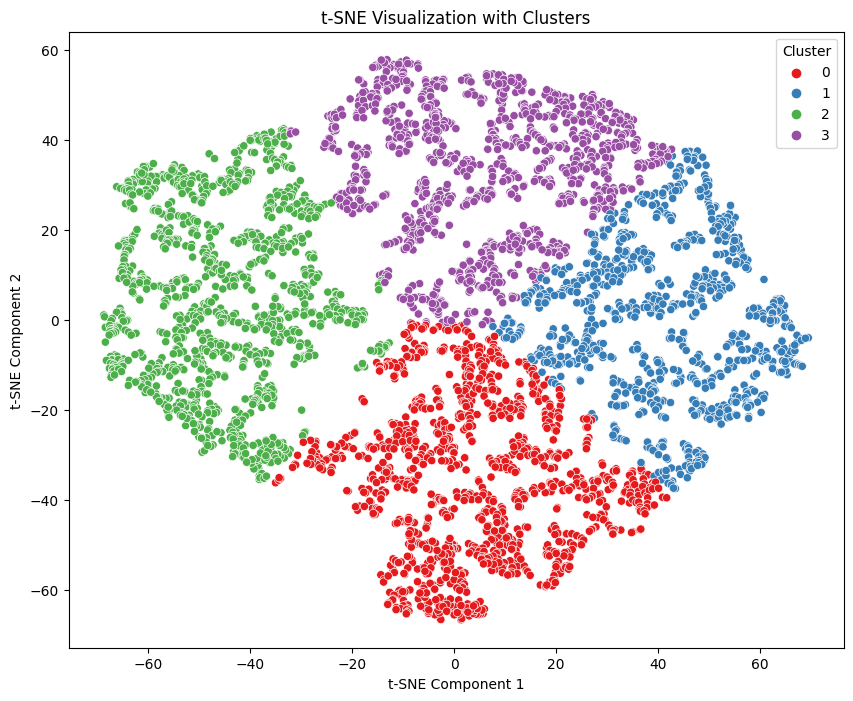

In [9]:
# Exclude categorical columns before PCA
num_cols = df.select_dtypes(include='number')

# Standardize numerical features for PCA
scaler = StandardScaler()
scaled_data = scaler.fit_transform(num_cols)

# Apply PCA to reduce dimensionality while retaining important features
pca = PCA(n_components=min(num_cols.shape[0], num_cols.shape[1]))
pca_result = pca.fit_transform(scaled_data)

# Add PCA results to the DataFrame
for i in range(pca_result.shape[1]):
    df[f'PCA_Component_{i+1}'] = pca_result[:, i]

# Apply t-SNE on the PCA-reduced feature space
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(pca_result)
df['t-SNE_Component_1'] = tsne_result[:, 0]
df['t-SNE_Component_2'] = tsne_result[:, 1]

# Define the number of clusters (4 clusters)
K = 4

# Explicitly set the value of 'n_init'
kmeans = KMeans(n_clusters=K, n_init=10, random_state=42)

# Perform K-means clustering on the t-SNE-reduced feature space
df['Cluster'] = kmeans.fit_predict(tsne_result)

# Create a scatter plot of the t-SNE result with cluster coloring
plt.figure(figsize=(10, 8))
sns.scatterplot(x='t-SNE_Component_1', y='t-SNE_Component_2', hue='Cluster', data=df, palette='Set1')
plt.title('t-SNE Visualization with Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Cluster', loc='upper right')
plt.show()

In [10]:
# Calculate cluster-specific metrics
cluster_metrics = df.groupby('Cluster').agg({
    'Recency': 'mean',            
    'OrderFrequency': 'mean',    
    'TotalSpending': 'mean',     
    'BasketSize': 'mean',        
}).reset_index()

# Rename the columns for clarity
cluster_metrics.columns = ['Cluster', 'AvgRecency', 'AvgPurchaseFrequency', 'AvgSpending', 'AvgBasketSize']

# Print or display the cluster metrics
print(cluster_metrics)

   Cluster  AvgRecency  AvgPurchaseFrequency  AvgSpending  AvgBasketSize
0        0   39.610127              3.480169    72.338354     183.468147
1        1   18.116402             13.607407   637.567037     193.714081
2        2  236.227663              1.824742    40.060902     140.061690
3        3   54.759740              2.859926    82.526512     275.452446


In [11]:
distinguishing_characteristics = {}

for cluster in range(len(cluster_metrics)):
    cluster_row = cluster_metrics.iloc[cluster]
    cluster_num = cluster_row['Cluster']
    cluster_name = f"Cluster {int(cluster_num)}"
    
    highest_value_column = cluster_row[1:].idxmax()  
    highest_value = cluster_row[highest_value_column]  
    
    distinguishing_characteristics[cluster_name] = {
        'Characteristic': highest_value_column,
        'HighestValue': highest_value
    }

# Print the distinguishing characteristics for each cluster
for cluster, char_info in distinguishing_characteristics.items():
    print(f"{cluster} has the highest {char_info['Characteristic']} ({char_info['HighestValue']}).")

Cluster 0 has the highest AvgBasketSize (183.4681474175145).
Cluster 1 has the highest AvgSpending (637.567037037037).
Cluster 2 has the highest AvgRecency (236.22766323024055).
Cluster 3 has the highest AvgBasketSize (275.45244644296133).


- From Code Above you can see that Cluster 1 doesn't have a distinguishing characteristics 
- so, we will compare all clusters with cluster 1 to have a better look
- These comparisons provide a detailed understanding of how each cluster differs from Cluster 1 across these specific characteristics


In [12]:
# Identify unique features for Cluster 1 compared to other clusters
unique_features = {}

for cluster in range(len(cluster_metrics)):
    if cluster == 1:
        continue  # Skip Cluster 1
        
    cluster_row = cluster_metrics.iloc[cluster]
    cluster_num = cluster_row['Cluster']
    cluster_name = f"Cluster {int(cluster_num)}"
    
    unique_features[cluster_name] = {
        'Recency': cluster_metrics.loc[1, 'AvgRecency'] - cluster_row['AvgRecency'],
        'PurchaseFrequency': cluster_metrics.loc[1, 'AvgPurchaseFrequency'] - cluster_row['AvgPurchaseFrequency'],
        'Spending': cluster_metrics.loc[1, 'AvgSpending'] - cluster_row['AvgSpending'],
        'BasketSize': cluster_metrics.loc[1, 'AvgBasketSize'] - cluster_row['AvgBasketSize']
    }

# Print the unique features for Cluster 1 compared to other clusters
for cluster, unique_info in unique_features.items():
    print(f"{cluster} has unique features compared to Cluster 1:")
    print(f"   -  Recency: {unique_info['Recency']:.2f}")
    print(f"   -  Purchase Frequency: {unique_info['PurchaseFrequency']:.2f}")
    print(f"   -  Spending: {unique_info['Spending']:.2f}")
    print(f"   -  Basket Size: {unique_info['BasketSize']:.2f}")

Cluster 0 has unique features compared to Cluster 1:
   -  Recency: -21.49
   -  Purchase Frequency: 10.13
   -  Spending: 565.23
   -  Basket Size: 10.25
Cluster 2 has unique features compared to Cluster 1:
   -  Recency: -218.11
   -  Purchase Frequency: 11.78
   -  Spending: 597.51
   -  Basket Size: 53.65
Cluster 3 has unique features compared to Cluster 1:
   -  Recency: -36.64
   -  Purchase Frequency: 10.75
   -  Spending: 555.04
   -  Basket Size: -81.74


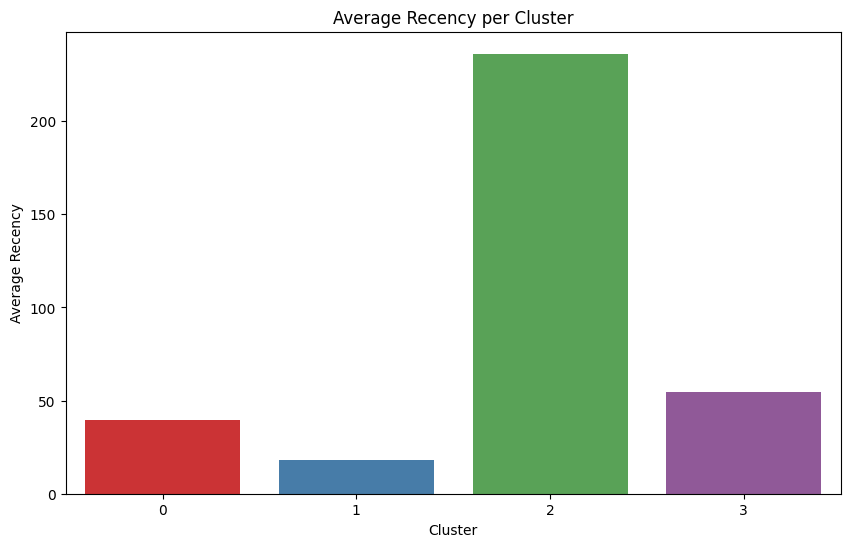

In [13]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='AvgRecency', data=cluster_metrics, palette='Set1')
plt.title('Average Recency per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Recency')
plt.show()

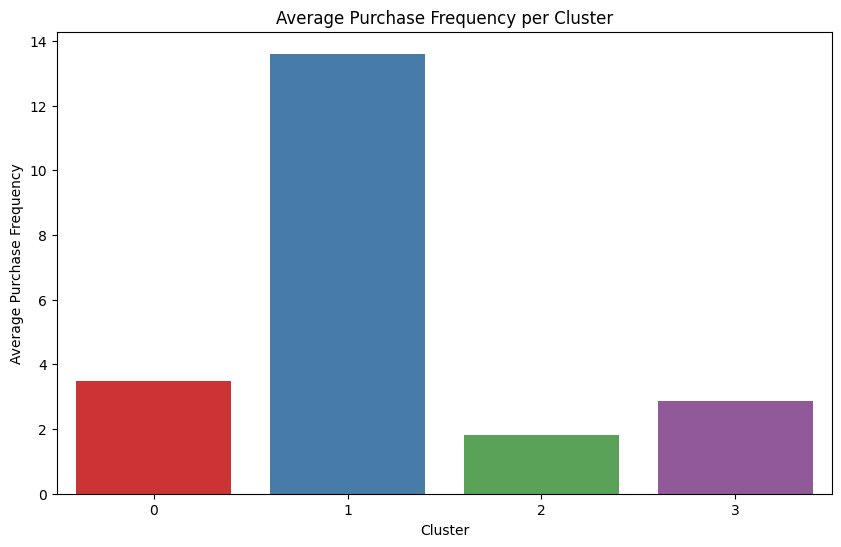

In [14]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='AvgPurchaseFrequency', data=cluster_metrics, palette='Set1')
plt.title('Average Purchase Frequency per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Purchase Frequency')
plt.show()

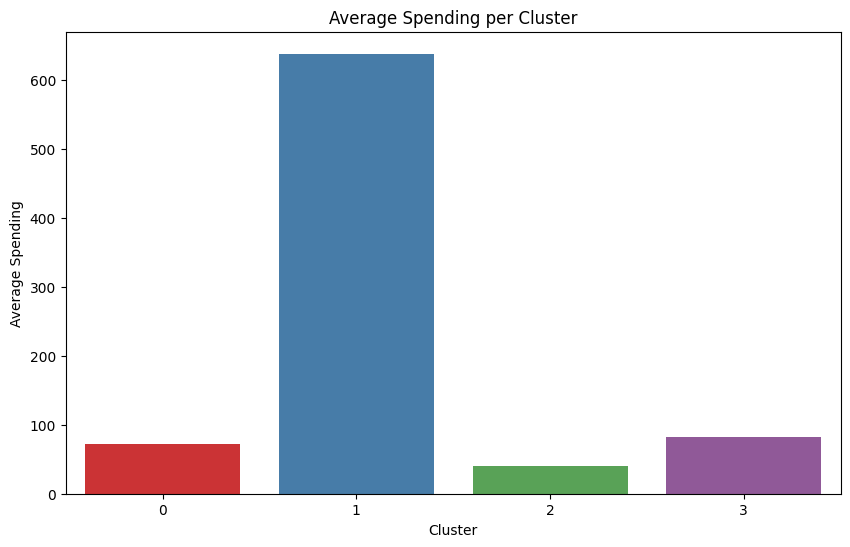

In [15]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='AvgSpending', data=cluster_metrics, palette='Set1')
plt.title('Average Spending per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Spending')
plt.show()

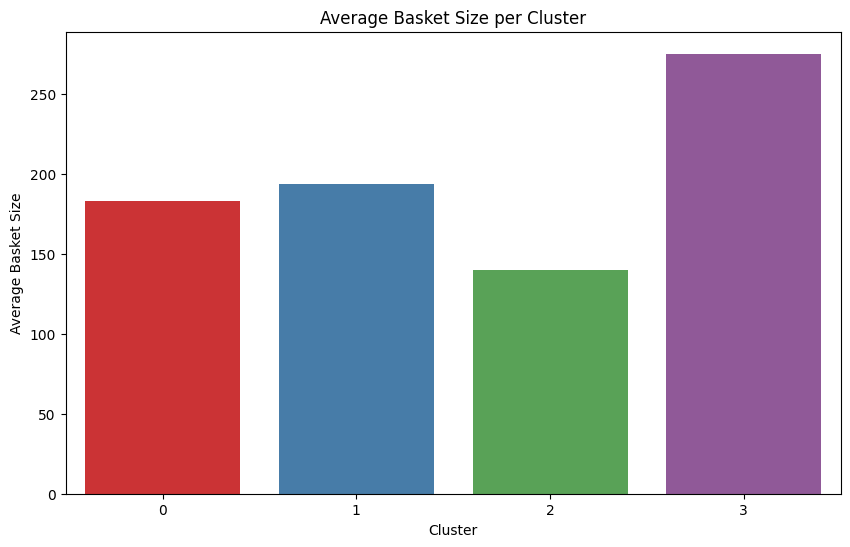

In [16]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='AvgBasketSize', data=cluster_metrics, palette='Set1')
plt.title('Average Basket Size per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Basket Size')
plt.show()

For K=2:
  - Silhouette Score: 0.38
  - WCSS: 5274681.00
For K=3:
  - Silhouette Score: 0.42
  - WCSS: 3149205.50
For K=4:
  - Silhouette Score: 0.41
  - WCSS: 2218604.50
For K=5:
  - Silhouette Score: 0.38
  - WCSS: 1859292.75
For K=6:
  - Silhouette Score: 0.39
  - WCSS: 1510103.00
For K=7:
  - Silhouette Score: 0.40
  - WCSS: 1213395.25
For K=8:
  - Silhouette Score: 0.39
  - WCSS: 1049607.50
For K=9:
  - Silhouette Score: 0.39
  - WCSS: 932617.12
For K=10:
  - Silhouette Score: 0.39
  - WCSS: 841514.00


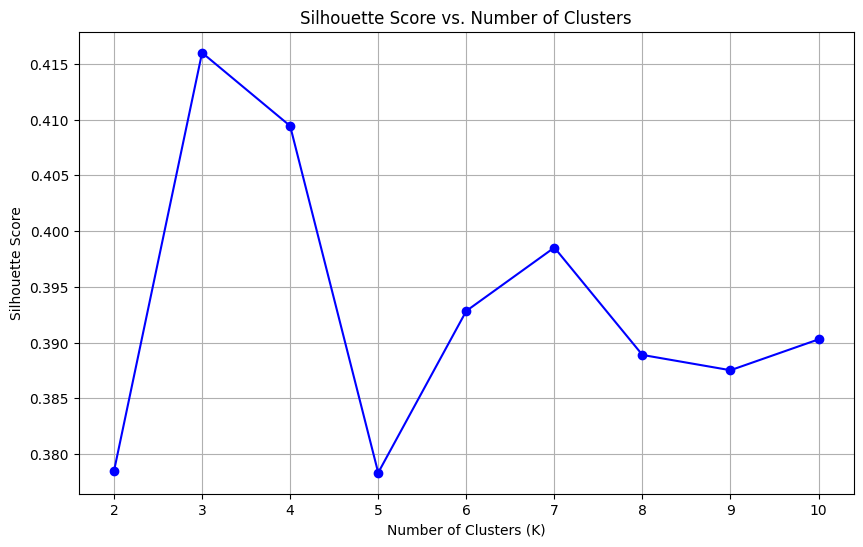

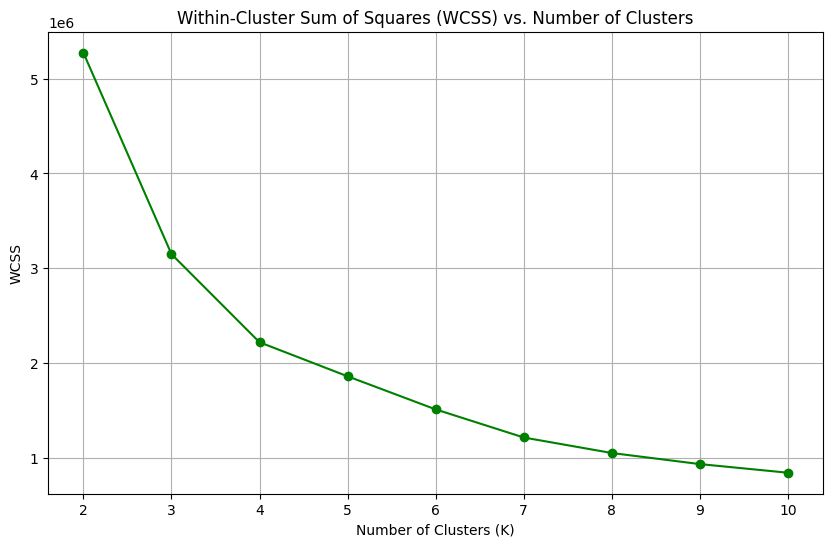

In [17]:

silhouette_scores = []
wcss = []

# Create a range of K values to try
K_range = range(2, 11)

for K in K_range:
    # Fit K-means clustering for each K
    kmeans = KMeans(n_clusters=K, n_init=10, random_state=42)
    kmeans.fit(tsne_result)  # Use t-SNE result for clustering
    
    # Calculate the silhouette score for the current K
    silhouette_avg = silhouette_score(tsne_result, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

    # Calculate the within-cluster sum of squares (WCSS)
    wcss.append(kmeans.inertia_)
    
    print(f"For K={K}:")
    print(f"  - Silhouette Score: {silhouette_avg:.2f}")
    print(f"  - WCSS: {wcss[-1]:.2f}")

# Plot the silhouette scores to visualize the optimal number of clusters
plt.figure(figsize=(10, 6))
plt.plot(K_range, silhouette_scores, marker='o', linestyle='-', color='b')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

# Plot the WCSS to find the "elbow point" for choosing K
plt.figure(figsize=(10, 6))
plt.plot(K_range, wcss, marker='o', linestyle='-', color='g')
plt.title('Within-Cluster Sum of Squares (WCSS) vs. Number of Clusters')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [18]:
# Calculate the pairwise distances between data points in the t-SNE-reduced space
pairwise_dist = pairwise_distances(tsne_result)
total_cohesion = 0
total_separation = 0

# Iterate through each cluster
for cluster in range(K):
    cluster_indices = np.where(kmeans.labels_ == cluster)[0]

    # Calculate cohesion for the current cluster
    cohesion = np.mean(pairwise_dist[cluster_indices][:, cluster_indices])
    total_cohesion += cohesion

    # Calculate separation for the current cluster
    other_clusters_indices = np.where(kmeans.labels_ != cluster)[0]
    separation = np.mean(pairwise_dist[cluster_indices][:, other_clusters_indices])
    total_separation += separation

average_cohesion = total_cohesion / K
average_separation = total_separation / K

# Print or display the cohesion and separation metrics
print(f"Average Cohesion: {average_cohesion:.2f}")
print(f"Average Separation: {average_separation:.2f}")

Average Cohesion: 17.55
Average Separation: 61.88


# Conclusion
## - Interpretation and Insights into Customer Segments
#### Cluster 0
- This cluster exhibits the highest average recency, indicating that these customers have not made purchases recently. 
- They also have a relatively low average purchase frequency and spending. 
- Their basket size is moderate. These customers might be considered as inactive or lapsed customers.

#### Cluster 1 
- This cluster doesn't have a distinguishing characteristic compared to other clusters. 
- It represents a group of customers with no specific standout behavior. 
- Further analysis might be needed to understand their preferences better.

#### Cluster 2 Customers in this cluster have a shorter recency, indicating recent purchases. 
- They also exhibit a high average purchase frequency, spending, and a moderate basket size. 
- This group appears to be active and frequent shoppers.

#### Cluster 3 
- This cluster has a relatively low average recency, indicating recent purchases. 
- However, they have the highest average purchase frequency, suggesting they are highly frequent shoppers. 
- They also have moderate spending and a significantly larger basket size than other clusters, indicating large purchases. 
- These customers are valuable and should be targeted for retention and upselling.

